# Credit Card Transaction Analysis
# Aisling Towey - 13th May 2019

### Analysis Objective & Data Overview
The objective of this analysis is to explore transaction data to identify what characteristics are most closely related to a transaction being fraudulent or not.

The data consists of 10 variables and 594643 observations each representing a transaction and can be found at https://www.kaggle.com/ntnu-testimon/banksim1#bs140513_032310.csv. The outcome variable labelled 'fraud' is a binary variable with '1' representing a fraudulent transaction and '0' representing a non-fraudulent transaction. As the outcome variable is known and is binary, it is evident that this is a supervised learning classification problem.

### Data Exploration
First import all required modules and read in the data

In [41]:
#import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance
import warnings
warnings.filterwarnings('ignore')

In [42]:
#import os
#os.getcwd()
#if need to change use os.chdir()

In [43]:
#read in data
fraud = pd.read_csv("A2 data.csv")

Begin to carry out basic exploration of the data

In [44]:
#basic eda
fraud.head()

,step,customer,age,gender,zipcodeOri,merchant,zipMerchant,category,amount,fraud
0,0,'C1093826151','4','M','28007','M348934600','28007','es_transportation',4.55,0
1,0,'C352968107','2','M','28007','M348934600','28007','es_transportation',39.68,0
2,0,'C2054744914','4','F','28007','M1823072687','28007','es_transportation',26.89,0
3,0,'C1760612790','3','M','28007','M348934600','28007','es_transportation',17.25,0
4,0,'C757503768','5','M','28007','M348934600','28007','es_transportation',35.72,0


In [45]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 10 columns):
step           594643 non-null int64
customer       594643 non-null object
age            594643 non-null object
gender         594643 non-null object
zipcodeOri     594643 non-null object
merchant       594643 non-null object
zipMerchant    594643 non-null object
category       594643 non-null object
amount         594643 non-null float64
fraud          594643 non-null int64
dtypes: float64(1), int64(2), object(7)
memory usage: 45.4+ MB


In [46]:
fraud.shape

(594643, 10)

In [47]:
type(fraud)

pandas.core.frame.DataFrame

In [48]:
fraud.describe()

,step,amount,fraud
count,594643.000000,594643.000000,594643.000000
mean,94.986827,37.890135,0.012108
std,51.053632,111.402831,0.109369
min,0.000000,0.000000,0.000000
25%,52.000000,13.740000,0.000000
50%,97.000000,26.900000,0.000000
75%,139.000000,42.540000,0.000000
max,179.000000,8329.960000,1.000000


Check for missing values in the dataset

In [49]:
#check for missing value
fraud.isnull().sum()

step           0
customer       0
age            0
gender         0
zipcodeOri     0
merchant       0
zipMerchant    0
category       0
amount         0
fraud          0
dtype: int64

Check for duplicates

In [50]:
#check for duplicated
fraud.duplicated().sum()

0

I noticed was that the two zip columns had zero variance so could be removed

In [51]:
#remove zip columns as they have zero variance
fraud.loc[:,["zipMerchant", "zipcodeOri"]]

fraud = fraud.drop(columns=["zipMerchant", "zipcodeOri"]) 

In [52]:
#ensure columns have been dropped
fraud.info()
fraud.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 594643 entries, 0 to 594642
Data columns (total 8 columns):
step        594643 non-null int64
customer    594643 non-null object
age         594643 non-null object
gender      594643 non-null object
merchant    594643 non-null object
category    594643 non-null object
amount      594643 non-null float64
fraud       594643 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 36.3+ MB


,step,customer,age,gender,merchant,category,amount,fraud
0,0,'C1093826151','4','M','M348934600','es_transportation',4.55,0
1,0,'C352968107','2','M','M348934600','es_transportation',39.68,0
2,0,'C2054744914','4','F','M1823072687','es_transportation',26.89,0
3,0,'C1760612790','3','M','M348934600','es_transportation',17.25,0
4,0,'C757503768','5','M','M348934600','es_transportation',35.72,0


There appeared to be quotation marks around all columns names which could be removed

In [53]:
#remove all quotation marks in columns where they exist
fraud['customer'] = fraud['customer'].str.strip('\'')
fraud['age'] = fraud['age'].str.strip('\'')
fraud['gender'] = fraud['gender'].str.strip('\'')
fraud['merchant'] = fraud['merchant'].str.strip('\'')
fraud['category'] = fraud['category'].str.strip('\'')


In [54]:
#ensure they have been removed
fraud.head()

,step,customer,age,gender,merchant,category,amount,fraud
0,0,C1093826151,4,M,M348934600,es_transportation,4.55,0
1,0,C352968107,2,M,M348934600,es_transportation,39.68,0
2,0,C2054744914,4,F,M1823072687,es_transportation,26.89,0
3,0,C1760612790,3,M,M348934600,es_transportation,17.25,0
4,0,C757503768,5,M,M348934600,es_transportation,35.72,0


In [55]:
#check help documentation for astype
#fraud.astype?

#double question mark shows the code that was used to create the function
#fraud.astype??http://localhost:8888/notebooks/Desktop/Jupyter/fraud.ipynb#

In [56]:
#originally had recoded as below but unlike r this does not seem to work for the models in python
#recode 0's and 1's to yes and no in outcome variable fraud
#fraud["fraud"] = fraud["fraud"].replace(0, "No")
#fraud["fraud"] = fraud["fraud"].replace(1, "Yes")

#use value_counts() to ensure this has occured
#fraud["fraud"].value_counts()

Check the distribution of the amount variable. Although outliers exist these cannot be removed as it is important to understand the high amount transactions as well as the low amount transactions.

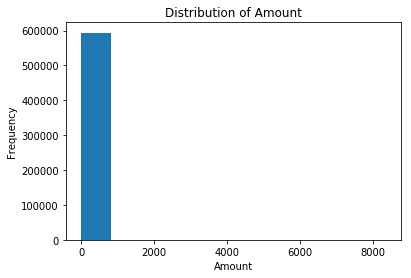

In [57]:
#check the distribution of amount
fraud.plot(kind = 'hist', y = 'amount', legend = False)
plt.title("Distribution of Amount")
plt.xlabel("Amount")
plt.show()

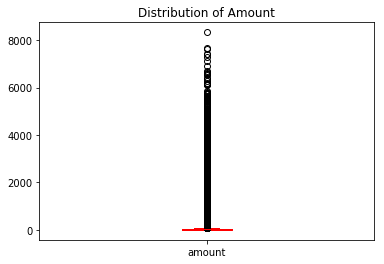

In [58]:
#check the distribution of amount
fraud.plot(kind = 'box', y = 'amount', color = 'r')
plt.title("Distribution of Amount")
plt.show()

Check are there transactions of 0 within amount which could be removed. 52 were found so these were removed as none of them were fradulent.

In [59]:
#check for transactions of amount 0
fraud['amount'].loc[fraud.amount == 0].count() 
zero_tran = fraud.loc[fraud.amount == 0]

#check if these 52 transactions are fradulent
zero_tran[['fraud','amount']]
type(zero_tran)


pandas.core.frame.DataFrame

In [60]:
fraud.shape

(594643, 8)

In [61]:
#remove the amounts equal to 0
fraud = fraud.loc[fraud.amount != 0]

#check the shape to ensure this has happened
fraud.shape

(594591, 8)

Explore the age categories

In [62]:
#check the categories within age
fraud.age.unique
fraud["age"].value_counts()

2    187289
3    147115
4    109018
5     62638
1     58130
6     26772
0      2452
U      1177
Name: age, dtype: int64

Show the split between fradulent and non fradulent transactions. It was found that there was a large imbalance in the response variable with most transactions proving to be non-fraudulent. To deal with this imbalance, the smote function was used further on in the analysis. Smote up samples some of the non-fraudulent transactions in the dataset and down samples the non-fraudulent transactions to balance the dataset. Models can then be efficiently used on the dataset to predict fraud.

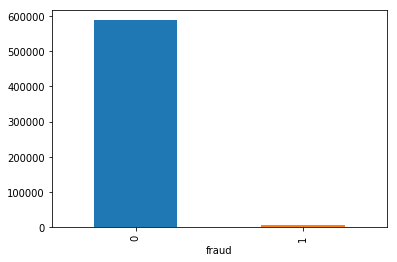

In [63]:
#show the split between fradulent and non fradulent transactions
fraud.groupby('fraud')['fraud'].count().plot(kind = 'bar')

Check the distribution of amount by category. From the data and the plot it is evident that any transaction with an amount greater than 2150 was fraudulent and was in the travel category.

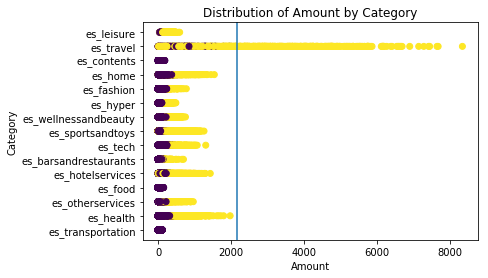

In [64]:
plt.scatter(fraud.amount, fraud.category, c = fraud.fraud)
plt.axvline(x=2150)
plt.title("Distribution of Amount by Category")
plt.xlabel("Amount")
plt.ylabel("Category")
plt.show()

Explore the merchant variable. Note that the top 2 merchants account for approx 500000 transactions and none of these are fradulent.

In [65]:
pd.crosstab(fraud.merchant,fraud.fraud)

fraud,0,1
merchant,,
M1053599405,6821,0
M117188757,21,0
M1198415165,1222,358
M1294758098,7,184
M1313686961,527,0
M1352454843,370,0
M1353266412,14,64
M1400236507,776,0
M1416436880,220,0


Explore the category variable. Note that no transactions in the transportation, food or contents categories were found to be fraudulent. 

In [66]:
pd.crosstab(fraud.category,fraud.fraud)

fraud,0,1
category,,
es_barsandrestaurants,6253,120
es_contents,885,0
es_fashion,6338,116
es_food,26250,0
es_health,14437,1696
es_home,1684,302
es_hotelservices,1196,548
es_hyper,5818,280
es_leisure,25,474


Change categorical variables to numerical in order to run smote

Originally I was going to use smotenc to balance the dataset but was taking too long on my machine so need to change categoricals to numericals so that smote runs. See more on this further down.

In [68]:
#originally was going to use smotenc to balance the dataset but was taking too long on my machine so need to change categoricals to numericals so that smote runs
col_categorical = fraud.select_dtypes(include= ['object']).columns
for col in col_categorical:
    fraud[col] = fraud[col].astype('category')
#change categorical values to numeric values
fraud[col_categorical] = fraud[col_categorical].apply(lambda x: x.cat.codes)
fraud.head(5)

,step,customer,age,gender,merchant,category,amount,fraud
0,0,210,4,2,30,12,4.55,0
1,0,2753,2,2,30,12,39.68,0
2,0,2285,4,1,18,12,26.89,0
3,0,1650,3,2,30,12,17.25,0
4,0,3585,5,2,30,12,35.72,0


In [67]:
#check the types have changed
fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594591 entries, 0 to 594642
Data columns (total 8 columns):
step        594591 non-null int64
customer    594591 non-null object
age         594591 non-null object
gender      594591 non-null object
merchant    594591 non-null object
category    594591 non-null object
amount      594591 non-null float64
fraud       594591 non-null int64
dtypes: float64(1), int64(2), object(5)
memory usage: 40.8+ MB


### Model

Split the independent and dependent variables so the model can be trained 

In [76]:
#split independent and dependent variables
X = fraud.drop(['fraud'],axis=1)
y = fraud['fraud']
print(X.head(),"\n")
print(y.head())

   step  customer  age  gender  merchant  category  amount
0     0       210    4       2        30        12    4.55
1     0      2753    2       2        30        12   39.68
2     0      2285    4       1        18        12   26.89
3     0      1650    3       2        30        12   17.25
4     0      3585    5       2        30        12   35.72 

0    0
1    0
2    0
3    0
4    0
Name: fraud, dtype: int64


Split the data into a training and test set

In [77]:
#split the data into a training and test spilt
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.3,random_state=42,shuffle=True,stratify=y)

In [78]:
#check the dimensions of the training and test set
X_train.shape
y_train.shape
X_test.shape
y_test.shape


(178378,)

In [79]:
X_train.head()

,step,customer,age,gender,merchant,category,amount
296036,97,3368,3,1,18,12,44.74
84304,31,3033,3,1,30,12,67.23
220856,75,3719,1,1,18,12,51.51
176168,61,3044,2,2,18,12,35.87
321713,104,84,2,2,45,3,32.72


As mentioned above use smote to balance just the training dataset so that there is a similar amount of fradulent and non fradulent transactions. smotenc should be used instead of smote as there are categorical features. Unfortunately fit_resample was taking too long on my machine after using smotenc so I had to change categorical variables to numerical and use smote.

In [80]:
#use smoteNC to balance training dataset
#smotenc should be used instead of smote as there are categorical features
#sm = SMOTENC(random_state=42, categorical_features=[1,2,3,4,5])
#X_res, y_res = sm.fit_resample(X_train, y_train)
#print(np.bincount(y_res))

In [81]:
#check the types have changed
fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 594591 entries, 0 to 594642
Data columns (total 8 columns):
step        594591 non-null int64
customer    594591 non-null int16
age         594591 non-null int8
gender      594591 non-null int8
merchant    594591 non-null int8
category    594591 non-null int8
amount      594591 non-null float64
fraud       594591 non-null int64
dtypes: float64(1), int16(1), int64(2), int8(4)
memory usage: 21.5 MB


In [82]:
#use smote to balance training dataset
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X_train, y_train)
print(np.bincount(y_res))

[411173 411173]


Create a random forest model

In [83]:
#Random forest
#train model on training smote data
clf_rf = RandomForestClassifier(n_estimators=25, random_state=12)
clf_rf.fit(X_res, y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=25, n_jobs=None,
            oob_score=False, random_state=12, verbose=0, warm_start=False)

Use the test set to check the performance and generalisation of the model to unseen data

In [84]:
#predict the test set values
y_pred = clf_rf.predict(X_test)

Use various metrics to check the performance of the model on the test set. The model achieves a ROC/AUC score of 0.9 which indicates a good model.

In [85]:
#check performance of model
print("Classification Report for Random Forest Classifier: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of Random Forest Classifier: \n", confusion_matrix(y_test,y_pred))
print("ROC Score: \n", roc_auc_score(y_test,y_pred))

#accuracy is not a good measure but leaving code here anyways
print("Accuracy Score: \n", accuracy_score(y_test,y_pred))


#note recall of the positive class is the same as sensitivity (TPR) and recall of the negative rate is the same as specificity (TNR)

Classification Report for Random Forest Classifier: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    176218
           1       0.82      0.80      0.81      2160

   micro avg       1.00      1.00      1.00    178378
   macro avg       0.91      0.90      0.90    178378
weighted avg       1.00      1.00      1.00    178378

Confusion Matrix of Random Forest Classifier: 
 [[175824    394]
 [   423   1737]]
ROC Score: 
 0.9009653998645616
Accuracy Score: 
 0.9954198387693549


Check the importance of the features to the model. Category, amount and merchant are the 3 most important variables to the model.

[0.00758533 0.01198199 0.01269824 0.05034281 0.24387321 0.34708335
 0.32643507]


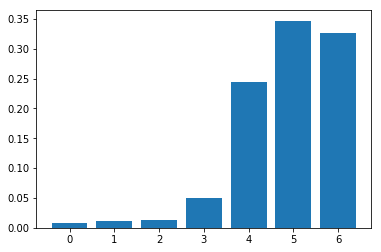

In [86]:
#check feature importance of model
print(clf_rf.feature_importances_)
feature_imp = pd.Series(clf_rf.feature_importances_).sort_values(ascending=False)
feature_imp

plt.bar(range(len(clf_rf.feature_importances_)), clf_rf.feature_importances_)
plt.show()


In [87]:
print(fraud.columns)

Index(['step', 'customer', 'age', 'gender', 'merchant', 'category', 'amount',
       'fraud'],
      dtype='object')


In [88]:
#one method to get column names beside importance number
print(dict(zip(fraud.columns, clf_rf.feature_importances_)))

{'step': 0.007585333064405024, 'customer': 0.01198199075023171, 'age': 0.012698241314611593, 'gender': 0.050342805181580276, 'merchant': 0.24387320687922334, 'category': 0.34708335469659957, 'amount': 0.32643506811334844}


In [89]:
#second method
important_features = pd.Series(data=clf_rf.feature_importances_,index=X_train.columns)
important_features.sort_values(ascending=False,inplace=True)
print(important_features)

category    0.347083
amount      0.326435
merchant    0.243873
gender      0.050343
age         0.012698
customer    0.011982
step        0.007585
dtype: float64


### Conclusion

In conclusion this analysis found that the variables amount, category and merchant were the variables that had characteristics that were closely related to whether a transaction was fraudulent or not. This finding was supported by both the exploratory data analysis and the random forest model. Various other models could be tested to find the best model for prediction in this scenario and paramaters could be tuned. 

The exploratory data analysis found that: any transaction with an amount greater than 2150 was fraudulent and was in the travel category;  no transactions in the transportation, food or contents categories were found to be fraudulent; and all transactions from the top 2 merchants were found to be non-fraudulent meaning fraudulent transactions occurred with merchants that had less transactions.
